## Import Packages

In [2]:
from tensorflow import keras#keras is useful for getting the components of a model
from tensorflow.data import AUTOTUNE
from tensorflow.keras.layers import RandomRotation, Input, RandomTranslation, Conv2D, MaxPool2D, Dense, BatchNormalization, Dropout, Flatten
import matplotlib.pyplot as plt #visualization library
import seaborn as sns #built on matplotlib, looks better, has more features
import tensorflow as tf #main framework for deep learning
import pandas as pd #data manipulation
import numpy as np #array manipulation (linear algebra)
import keras_tuner as kt
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Load Data
In the right tab you can see the imported data, to import the data just use pd.read_csv and copy the corresponding path.

In [3]:
train_data_input = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data_input = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

## View Dataset
view dataset using df.head(n) where n is the number of rows starting from the top. 

In [4]:
train_data_input.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Check for null values
Use df.isna() to get a dataframe of boolean values. In this case our dataset is already clean.

In [5]:
print('null values for train and test:',
    train_data_input.isna().sum().max(),
    test_data_input.isna().sum().max()
)

null values for train and test: 0 0


## Split into X and y
Use df.iloc to index through the rows and columns

In [6]:
def split_into_X_and_y(data):
    X = data.iloc[:,1:]
    y = data.iloc[:,0]
    return X, y

X_input, y_input = split_into_X_and_y(train_data_input)

## Visualize Distribution of Labels (check for class imbalance)

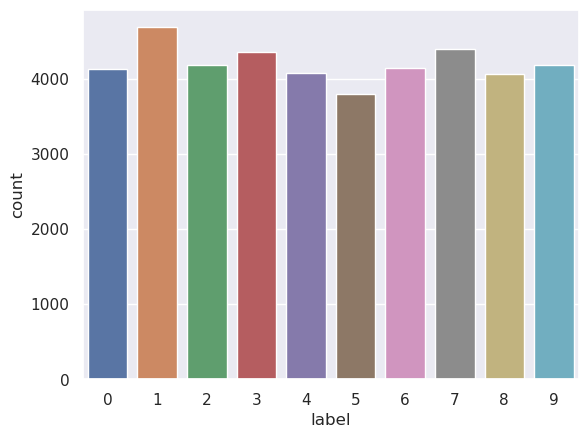

In [7]:
sns.set()
sns.countplot(x = y_input)
plt.show()

## Reshape into 2D Image

In [66]:
def reshape_into_image(X):
    return X.values.reshape(-1,28,28,1)

X = reshape_into_image(X_input)
X_test = reshape_into_image(test_data_input)
y = pd.get_dummies(y_input)

In [9]:
y

,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
41995,1,0,0,0,0,0,0,0,0,0
41996,0,1,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,1,0,0
41998,0,0,0,0,0,0,1,0,0,0


## Lets Look at the Images

In [10]:
def plot_examples(examples,rows = 3, cols = 3):
    plt.figure(figsize = (6,6))
    examples = examples[:rows*cols]
    for row in range(rows):
        for col in range(cols):
            i = cols*row+col
            plt.subplot(rows,cols,i+1)
            plt.imshow(examples[i], cmap = 'gray')
            plt.axis('off')

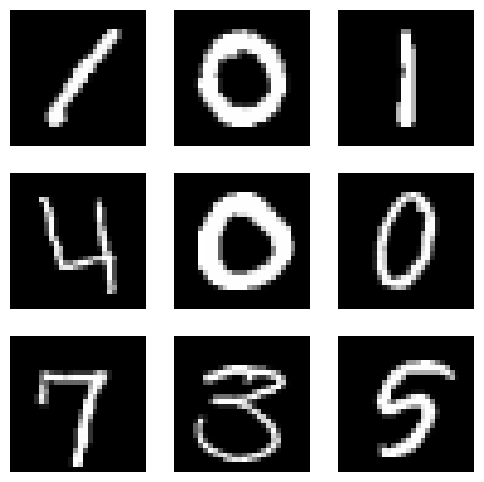

In [11]:
plot_examples(X)

## Normalize Images

In [67]:
X_norm = X/255.
X_test_norm = X_test/255.

## Add Augmentation

In [13]:
aug = keras.Sequential([
    Input(shape = (28,28,1)),
    RandomRotation(0.1, fill_mode = 'nearest'),
    RandomTranslation(0.15,0.15, fill_mode = 'nearest'),
    keras.layers.RandomBrightness(0.3, value_range = (0,1))
])

## View Augmentation Effect

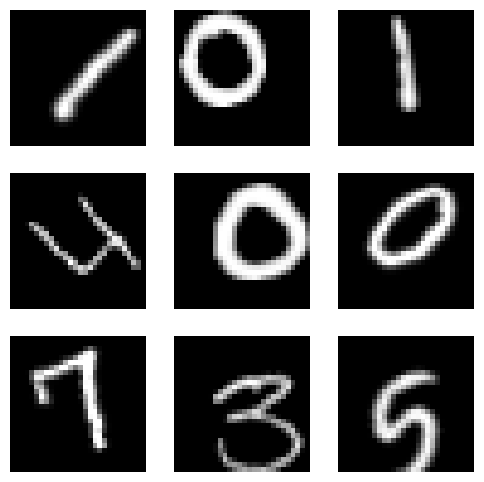

In [14]:
aug_data = aug(X_norm[:9])
plot_examples(aug_data)

## Split Into Training and Validation

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_norm,y, test_size = 0.2)

## Convert Into Tensorflow Dataset

In [16]:
def create_image_dataset(X,y):
    ds = tf.data.Dataset.from_tensor_slices((X,y))
    return ds

train_ds = create_image_dataset(X_train,y_train)
val_ds = create_image_dataset(X_val,y_val)

# Augment the Data and Prepare it for Training

In [17]:
def process_dataset(ds,batch_size,augment = False):
    if augment: ds = ds.map(lambda X,y: (aug(X),y), num_parallel_calls = AUTOTUNE)
    ds = ds.shuffle(3*batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds

BATCH_SIZE = 32

train_ds_proc = process_dataset(train_ds, BATCH_SIZE, True)
val_ds_proc = process_dataset(val_ds, BATCH_SIZE)

## Create a model function
Here I create a class as well in order to make the code look cleaner for tuning.

In [39]:
class MNIST_model:
    def __init__(self,hp):
        self.hpd = {} 
        
        self.hpd['learning_rate'] = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'log')
        self.hpd['beta_1'] = hp.Float('beta_1', min_value = 0.85, max_value = 0.99)
        
        self.hpd['conv_block_layers'] = hp.Int('conv_block_layers', min_value = 1, max_value = 5)
        self.hpd['filters'] = 2**hp.Int('filters', min_value = 5, max_value = 6)
            
        self.hpd['dense_layers'] = hp.Int('dense_layers', min_value = 3, max_value = 10)
        self.hpd['units'] = 2**hp.Int('units', min_value = 8, max_value = 12)
        
        self.hpd['dropout'] = hp.Float('dropout', min_value = 0.5, max_value = 1)
        self.hpd['weight_decay'] = hp.Float('weight_decay', min_value = 1e-4, max_value = 1e-2, sampling = 'log')
        
        
    def conv_block(self, filters, kernel_size):
        block = []
        for _ in range(self.hpd['conv_block_layers']):
            block.append(
                Conv2D(filters, kernel_size, activation = 'leaky_relu', kernel_initializer = 'he_normal', padding = 'same')
            )
        block.append(BatchNormalization())
        block.append(MaxPool2D())
        block.append(Dropout(self.hpd['dropout']))
        return block
    
    def dense_block(self, units):
        block = [Dense(units, activation = 'leaky_relu', kernel_initializer = 'he_normal'),
            BatchNormalization(),
            Dropout(self.hpd['dropout'])]
        return block
    
    def create_model(self):
        
        model = keras.Sequential([Input(shape = (28,28,1))])
        
        for i in range(2):
            for layer in self.conv_block((2**i)*self.hpd['filters'], 3):
                model.add(layer)
        
        model.add(Flatten())
        
        for i in range(self.hpd['dense_layers']):
            for layer in self.dense_block(self.hpd['units']):
                model.add(layer)
        
        model.add(Dense(10))
        
        opt = keras.optimizers.Adam(learning_rate = self.hpd['learning_rate'], beta_1 = self.hpd['beta_1'], weight_decay = self.hpd['weight_decay'])
        
        model.compile(loss = keras.losses.CategoricalCrossentropy(from_logits = True), 
                      optimizer = opt, 
                      metrics = ['accuracy','AUC'])
                
        return model

## Create the Tuner

In [40]:
tuner = kt.Hyperband(
    hypermodel=lambda hp: MNIST_model(hp).create_model(),
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=1,
    directory="/kaggle/working/results",
    overwrite = True,
    project_name="mnist"
)

## Hyperparameter Search

In [41]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'loss', patience = 0)
tuner.search(
    train_ds_proc, batch_size = BATCH_SIZE, 
    validation_data = val_ds_proc, validation_batch_size = BATCH_SIZE,
    callbacks = [early_stop]
)

Trial 32 Complete [00h 03m 42s]
val_accuracy: 0.11023809760808945

Best val_accuracy So Far: 0.9769047498703003
Total elapsed time: 02h 13m 59s

Search: Running Trial #33

Value             |Best Value So Far |Hyperparameter
0.0031287         |0.0021365         |learning_rate
0.96906           |0.89594           |beta_1
4                 |5                 |conv_block_layers
6                 |5                 |filters
6                 |8                 |dense_layers
11                |10                |units
0.59683           |0.51504           |dropout
0.00019683        |0.0013309         |weight_decay
3                 |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
2                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/3


2023-09-02 14:05:17.922138: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1050/1050 [==============================] - 48s 37ms/step - loss: 1.6713 - accuracy: 0.6106 - auc: 0.8021 - val_loss: 1.3250 - val_accuracy: 0.8423 - val_auc: 0.8350


KeyboardInterrupt: 

## Get the Best Model

In [42]:
model = tuner.get_best_models(1)[0]
model.build(input_shape = (28,28,1))

## Continue Training Until Convergence

In [57]:
learning_rate_scheduler = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4*10**(-epoch/5)
)
model.fit(
    train_ds_proc, batch_size = BATCH_SIZE, epochs = 10,
    validation_data = val_ds_proc, validation_batch_size = BATCH_SIZE,
    callbacks = [learning_rate_scheduler]
)

Epoch 1/10
1050/1050 [==============================] - 41s 39ms/step - loss: 0.0877 - accuracy: 0.9754 - auc: 0.9103 - val_loss: 0.0600 - val_accuracy: 0.9825 - val_auc: 0.9490 - lr: 1.0000e-04
Epoch 2/10
1050/1050 [==============================] - 39s 37ms/step - loss: 0.0875 - accuracy: 0.9757 - auc: 0.9105 - val_loss: 0.0649 - val_accuracy: 0.9812 - val_auc: 0.9486 - lr: 6.3096e-05
Epoch 3/10
1050/1050 [==============================] - 39s 37ms/step - loss: 0.0864 - accuracy: 0.9758 - auc: 0.9103 - val_loss: 0.0637 - val_accuracy: 0.9813 - val_auc: 0.9480 - lr: 3.9811e-05
Epoch 4/10
1050/1050 [==============================] - 39s 37ms/step - loss: 0.0838 - accuracy: 0.9756 - auc: 0.9102 - val_loss: 0.0640 - val_accuracy: 0.9819 - val_auc: 0.9492 - lr: 2.5119e-05
Epoch 5/10
1050/1050 [==============================] - 40s 38ms/step - loss: 0.0861 - accuracy: 0.9761 - auc: 0.9096 - val_loss: 0.0633 - val_accuracy: 0.9821 - val_auc: 0.9491 - lr: 1.5849e-05
Epoch 6/10
1050/1050 [===

## Save Model

In [61]:
output_path = 'best_model.h5'
model.save(output_path)

## Get Predictions and Save as Csv

In [95]:
predictions = tf.nn.softmax(model.predict(X_test_norm), axis = -1)

875/875 [==============================] - 3s 3ms/step


In [96]:
answers = np.argmax(predictions, axis = -1)
solution = pd.DataFrame(answers, columns = ['Label'])
solution.index += 1
solution.index.name = 'ImageId'
solution.head()

,Label
ImageId,
1,2
2,0
3,9
4,0
5,3


In [97]:
solution.to_csv('MNIST_solution.csv')